# **Semantic Segmentation Using HAGDAVS Dataset**

**RETO MeIA**

* Irma Angélica García González (TECNM)
* Leonardo Octavio Perez De La Torre (UDG)
* Andrés Felipe Báez Mesa (UNAL)
* Jaime Andrés Carrillo Cantillo (UNAL)
* Andrey Yecid Espinosa Gonzalez (UNAL)
* Josué Raziel Huerta Ruiz (UNAM)
* Gerardo Antonio Macías Hernández (UNAM)
* Erick Gino Livia Mendez (UNMSM)
* Marcelo Julián Díaz Miranda (FPUNA)
* Shyrley Flor 

### **Import Libraries**

In [1]:
%%capture
!pip uninstall tensorflow -y
!pip uninstall tensorflow-io -y
!pip install tensorflow
!pip install --no-deps tensorflow-io
!pip install -U scikit-learn

In [2]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import pathlib
from PIL import Image
import shutil
from tensorflow.keras.layers.experimental import preprocessing
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
import sklearn.metrics

from tensorflow.data import AUTOTUNE

## **Load Data**

This code performs the following actions:

1. Defines directory paths for the input data, including the folder containing RGB images and the folder containing masks.
2. Sets the destination folder path to save the modified images.
3. Creates the new destination folder if it doesn't exist.
4. Retrieves the list of file names in the masks folder.
5. Iterates over each file in the list and does the following:
   - Checks if the file name contains the text "MClass".
   - If it does, modifies the file name by replacing "MClass" with "RGB".
   - Creates an old file path and a new file path.
   - Copies the old file to the new path.

In summary, the code takes masks in the "MClass" format and copies them to a new folder, but changes their names to the "RGB" format.

In [3]:
data_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = data_dir / 'RGB'
masks_dir = data_dir / 'MASK'

folder_path = masks_dir  # Ruta de la carpeta que contiene las imágenes
new_folder_path = '/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/MASK'

# Crear la nueva carpeta si no existe
if os.path.exists(new_folder_path):
    shutil.rmtree(new_folder_path)
os.makedirs(new_folder_path, exist_ok=True)

# Obtener la lista de nombres de archivo en la carpeta
file_list = os.listdir(folder_path)

# Aplicar la modificación del nombre y crear nuevos archivos en la nueva carpeta
for filename in file_list:
    if "MClass" in filename:
        new_filename = filename.replace("MClass", "RGB")
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(new_folder_path, new_filename)
        shutil.copy2(old_path, new_path)

Realizamos la aumentació de data

Iniciamos con las transformaciones directamente en las imágenes

In [5]:
from PIL import Image
import os

carpeta_origen='/kaggle/input/hagdavs/HAGDAVS/RGB'
carpeta_destino='/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/RGB'
if os.path.exists(carpeta_destino):
    shutil.rmtree(carpeta_destino)
shutil.copytree(carpeta_origen, carpeta_destino)
archivos_origen=os.listdir(carpeta_origen)
for archivo in archivos_origen:
    ruta_origen=os.path.join(carpeta_origen, archivo)
    imagen=Image.open(ruta_origen)
    
    imagen_rotada=imagen.rotate(90)
    nombre_rotada=archivo.split('.')[0]+'_rotada.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_rotada)
    imagen_rotada.save(ruta_destino)

    imagen_rotada2=imagen.rotate(180)
    nombre_rotada2=archivo.split('.')[0]+'_rotada2.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_rotada2)
    imagen_rotada2.save(ruta_destino)
    
    imagen_flip=imagen.transpose(Image.FLIP_LEFT_RIGHT)
    nombre_flip=archivo.split('.')[0]+'_flip.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_flip)
    imagen_flip.save(ruta_destino)

    imagen_contraste=imagen.point(lambda p: p*1.5)
    nombre_contraste=archivo.split('.')[0]+'_contraste.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_contraste)
    imagen_contraste.save(ruta_destino)

Aplicamos las transformaciones a las máscaras

In [6]:
carpeta_origen='/kaggle/input/hagdavs/HAGDAVS/MASK'
carpeta_destino='/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/MASK'
archivos_origen=os.listdir(carpeta_origen)
for archivo in archivos_origen:
    ruta_origen=os.path.join(carpeta_origen, archivo)
    imagen=Image.open(ruta_origen)
    if "MClass" in archivo:
        new_archivo = archivo.replace("MClass", "RGB")
    
    imagen_rotada=imagen.rotate(90)
    nombre_rotada=new_archivo.split('.')[0]+'_rotada.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_rotada)
    imagen_rotada.save(ruta_destino)
    
    imagen_rotada2=imagen.rotate(180)
    nombre_rotada2=new_archivo.split('.')[0]+'_rotada2.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_rotada2)
    imagen_rotada2.save(ruta_destino)

    imagen_flip=imagen.transpose(Image.FLIP_LEFT_RIGHT)
    nombre_flip=new_archivo.split('.')[0]+'_flip.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_flip)
    imagen_flip.save(ruta_destino)

    imagen_contraste=imagen
    nombre_contraste=new_archivo.split('.')[0]+'_contraste.tif'
    ruta_destino=os.path.join(carpeta_destino, nombre_contraste)
    imagen_contraste.save(ruta_destino)

This code performs the following actions:

1. Defines directory paths for the image and mask folders.
2. Retrieves a list of file paths for the images and masks.
3. Creates empty lists to store image and mask patches.
4. Sets the desired patch size.
5. Defines a function to load and split the images and masks into patches.
   - It reads the image and mask files.
   - Removes the alpha channel from the images and masks.
   - Divides the image into patches based on the specified patch size.
   - Checks if all pixels in a mask patch are black, and if so, skips it.
   - Appends the image and mask patches to their respective lists.
6. Applies the load_and_split_patches function to each image and mask pair.
7. Converts the lists of patches into TensorFlow tensors.
8. Creates a dataset from the image and mask patches.

In summary, the code loads image and mask files, divides them into patches of a specified size, filters out patches with all-black masks, and creates a dataset for further processing or training.

In [7]:
import tensorflow as tf
import tensorflow_io as tfio
import pathlib

# Ruta a las carpetas de imágenes y máscaras
ima_dir = pathlib.Path('/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS')
images_dir = ima_dir / 'RGB'
m_dir = pathlib.Path('/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS')
mask_dir = m_dir / 'MASK'

# Obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.tif')])
mask_paths = sorted([str(path) for path in mask_dir.glob('*.tif')])

# Crear una lista para almacenar los parches de imágenes y máscaras
image_patches = []
mask_patches = []

# Tamaño del parche deseado
patch_size = (256, 256)


# Definir una función para cargar y dividir las imágenes y máscaras en parches
def load_and_split_patches(image_path, mask_path):
    image = tfio.experimental.image.decode_tiff(tf.io.read_file(image_path))
    mask = tfio.experimental.image.decode_tiff(tf.io.read_file(mask_path))

    # Eliminar el canal alfa de las imágenes y máscaras
    image = image[:, :, :3]
    mask = mask[:, :, :3]

    # Dividir la imagen en parches
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch_image = image[i:i+patch_size[0], j:j+patch_size[1], :]
            patch_mask = mask[i:i+patch_size[0], j:j+patch_size[1], :]

            # Verificar si todos los píxeles en el parche de la máscara son negros
            if tf.reduce_all(tf.math.equal(patch_mask, [0, 0, 0])):
                continue
                
            #patch_mask = convertir_colores(patch_mask)
            image_patches.append(patch_image)
            mask_patches.append(patch_mask)

    return None

# Aplicar la función de carga y división de parches a cada par de rutas de archivo
for image_path, mask_path in zip(image_paths, mask_paths):
    load_and_split_patches(image_path, mask_path)

# Convertir las listas de parches en tensores
image_patches = tf.convert_to_tensor(image_patches)
mask_patches = tf.convert_to_tensor(mask_patches)

# Crear un dataset a partir de los parches de imágenes y máscaras
dataset = tf.data.Dataset.from_tensor_slices((image_patches, mask_patches))

The size of images in dataset:

In [8]:
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None))>

## **Display Data**

Function for show the image, mask and prediction mask

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

## **Using only one class**

This code defines a function called `convertir_mascara` and applies it to a dataset using the `map` function.

The `convertir_mascara` function performs the following actions:

1. Casts the input mask tensor to `float32` data type.
2. Creates a new mask tensor filled with zeros, with dimensions `(256, 256, 1)`.
3. Assigns values corresponding to each class in the mask:
   - If all RGB values in the mask are `[0, 0, 0]`, assigns `0.0` to the corresponding pixel in the converted mask.
   - If all RGB values are `[255, 0, 0]`, assigns `0.0`.
   - If all RGB values are `[0, 255, 0]`, assigns `1.0`.
   - If all RGB values are `[0, 0, 255]`, assigns `0.0`.
4. Returns the converted mask.

The code then applies the `convertir_mascara` function to each element in the `dataset` using the `map` function. The `map` function takes a lambda function that applies the conversion function to each `(image, mask)` pair in the dataset, resulting in a new dataset named `mapped_dataset`. The images in the dataset remain unchanged, while the masks are converted using the `convertir_mascara` function.

In [10]:
def convertir_mascara(mascara):
    mascara = tf.cast(mascara, dtype=tf.float32)
    mascara_convertida = tf.zeros((256, 256, 1), dtype=tf.float32)

    # Asigna valores correspondientes a cada clase
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [255, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 255, 0]), axis=-1, keepdims=True), 1.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 255]), axis=-1, keepdims=True), 0.0, mascara_convertida)

    return mascara_convertida

mapped_dataset = dataset.map(lambda x, y: (x, convertir_mascara(y)))

This code defines a function called `filter_func` that filters the `mapped_dataset` based on certain criteria using the `filter` function.

The `filter_func` function performs the following actions:

1. Reshapes the mask tensor into a 1-dimensional tensor.
2. Uses `tf.unique` to obtain the unique classes present in the mask.
3. Checks if the number of unique classes (`tf.size(unique_classes)`) is greater than or equal to 2.
   - If there are two or more unique classes, it returns `True`, indicating that the image and mask pair should be included in the filtered dataset.
   - If there are fewer than two unique classes, it returns `False`, indicating that the image and mask pair should be filtered out.

The code then applies the `filter_func` function to each element in the `mapped_dataset` using the `filter` function. The `filter` function takes the lambda function `filter_func` as an argument and returns a new dataset named `filtered_dataset` that contains only the image and mask pairs that satisfy the filtering criteria.

In [11]:
import tensorflow as tf

def filter_func(image, mask):
    unique_classes = tf.unique(tf.reshape(mask, [-1]))[0]
    return tf.size(unique_classes) >= 2

filtered_dataset = mapped_dataset.filter(filter_func)

dataset_length = 0
for _ in filtered_dataset:
    dataset_length += 1

print("Longitud aproximada del dataset filtrado:", dataset_length)

Longitud aproximada del dataset filtrado: 5215


## **Splitting data**

train/test/val split

In [12]:
# dividir el dataset en conjuntos de entrenamiento, validación y prueba
total_samples = (dataset_length)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = filtered_dataset.take(train_size)
val_dataset = filtered_dataset.skip(train_size).take(val_size)
test_dataset = filtered_dataset.skip(train_size + val_size).take(test_size)

In [13]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

In [14]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

## **Unet**

In [15]:
#Definimos la ruta de guardado del modelo
checkpoint_path="/kaggle/working/semantic-segmentation-hagdavs/mejor_modelo.ckpt"
#Creamos el callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1.
    )



def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    #L1 y l2 regularización: Cuidado!!! provoca overfitting
    #x = layers.Dense(n_filters,activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
    
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))

    # encoder: contracting path - downsample
    # 0 - downsample Agregamos una capa más (Maximo accu_val=0.82 sin aumentation data)
    f0, p0 = downsample_block(inputs, 32)
    # 1 - downsample
    f1, p1 = downsample_block(p0, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - downsample Añadimos una capa (Máximo accu_val=0.96 sin aumentation data)
    f5, p5 = downsample_block(p4, 1024)
    # 6 - bottleneck 
    bottleneck = double_conv_block(p5, 2048)
    bottleneck = layers.Dropout(0.3)(bottleneck)

    # decoder: expanding path - upsample
    # 5- upsample Añadimos una capa
    u5 = upsample_block(bottleneck, f5, 1024)
    # 6 - upsample
    u6 = upsample_block(u5, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    #10 - upsample Agregamos una capa más
    u10 =upsample_block(u9, f0, 32)
#u5+ u10 max accu_val= 0.98
    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u10)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

#loss = keras.losses.sparse_categorical_crossentropy()

def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    loss = 1.0 - (intersection + 1.0) / (union + 1.0)  # Add epsilon to avoid division by zero
    return tf.reduce_mean(loss)

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(
                        from_logits=False,
                        label_smoothing=0.0,
                        axis=-1,
                        reduction="auto",
                        name="binary_crossentropy",),
                   #loss=dice_loss,
                  #loss=bce_dice_loss, #Los losses comentados nos generan overfitting
                  #loss=jaccard_loss,
                   #metrics=["accuracy"]) #Funciona bastante bien ac_val = 0.95
                   metrics= tf.keras.metrics.BinaryAccuracy(
                   name="binary_accuracy", dtype=None, threshold=0.5))

## **Training**

In [16]:
keras.backend.clear_session()
NUM_EPOCHS = 10
BATCH_SIZE = 16


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                               callbacks=[checkpoint_callback])

Epoch 1/10


2023-06-29 21:13:23.450996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


325/325 [==============================] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9712
Epoch 1: val_loss improved from inf to 1.50880, saving model to /kaggle/working/semantic-segmentation-hagdavs/mejor_modelo.ckpt
325/325 [==============================] - 316s 807ms/step - loss: 0.1012 - binary_accuracy: 0.9712 - val_loss: 1.5088 - val_binary_accuracy: 0.5093
Epoch 2/10
325/325 [==============================] - ETA: 0s - loss: 0.0733 - binary_accuracy: 0.9757
Epoch 2: val_loss improved from 1.50880 to 0.16437, saving model to /kaggle/working/semantic-segmentation-hagdavs/mejor_modelo.ckpt
325/325 [==============================] - 289s 889ms/step - loss: 0.0733 - binary_accuracy: 0.9757 - val_loss: 0.1644 - val_binary_accuracy: 0.9198
Epoch 3/10
325/325 [==============================] - ETA: 0s - loss: 0.0640 - binary_accuracy: 0.9788
Epoch 3: val_loss improved from 0.16437 to 0.11592, saving model to /kaggle/working/semantic-segmentation-hagdavs/mejor_modelo.ckpt
325/325 [===

## **Visualization of predictions**

In [17]:
def create_mask(pred_mask, threshold=0.2):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset, model, num):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


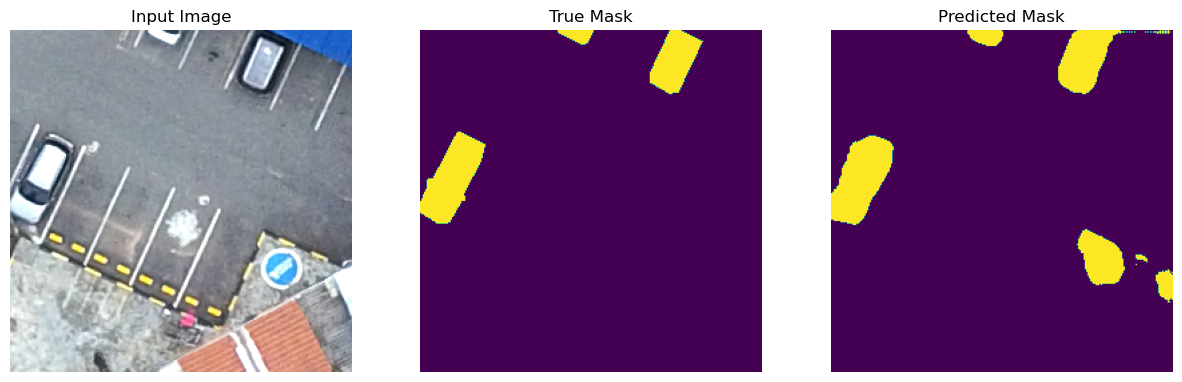

1/1 [==============================] - 0s 57ms/step


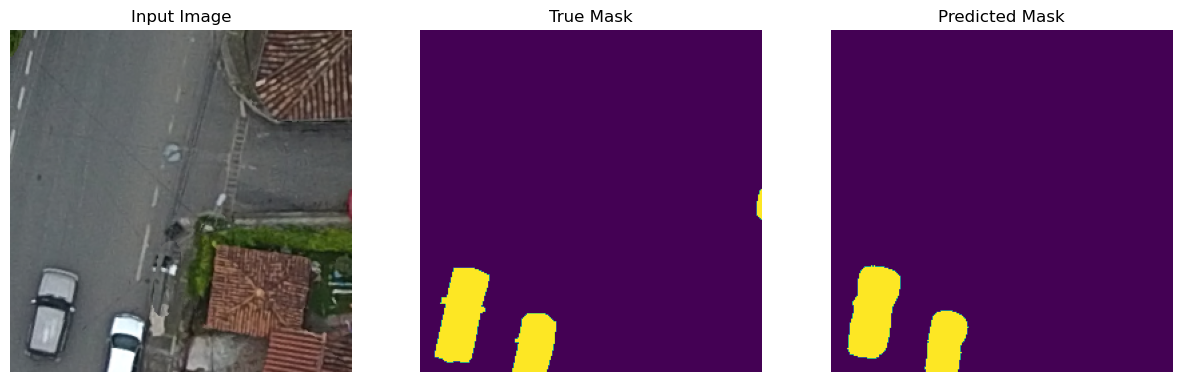

1/1 [==============================] - 0s 47ms/step


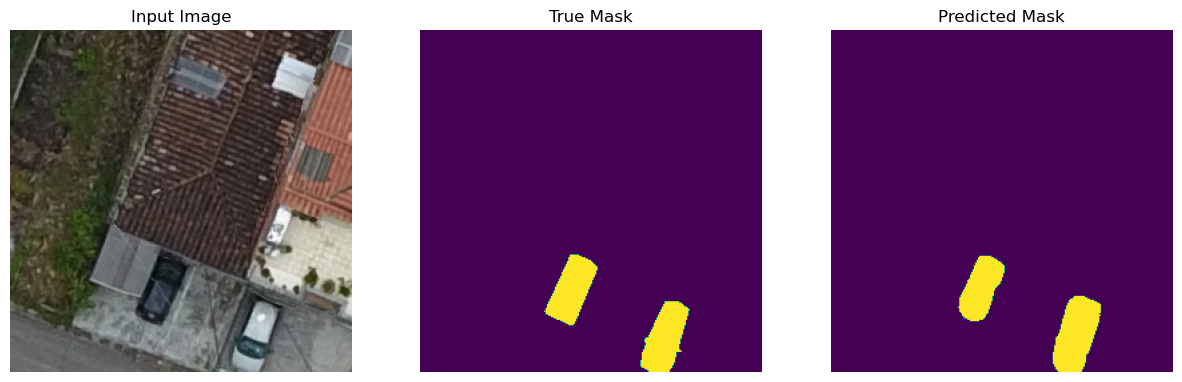

1/1 [==============================] - 0s 52ms/step


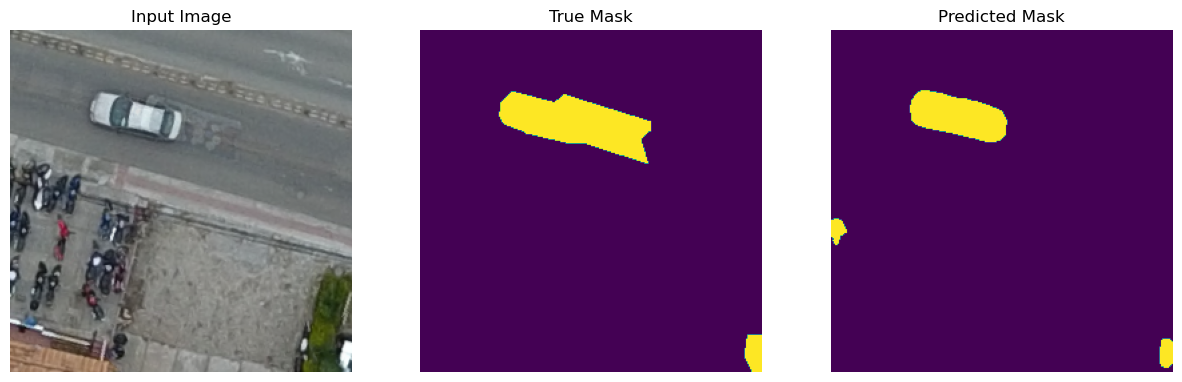

1/1 [==============================] - 0s 53ms/step


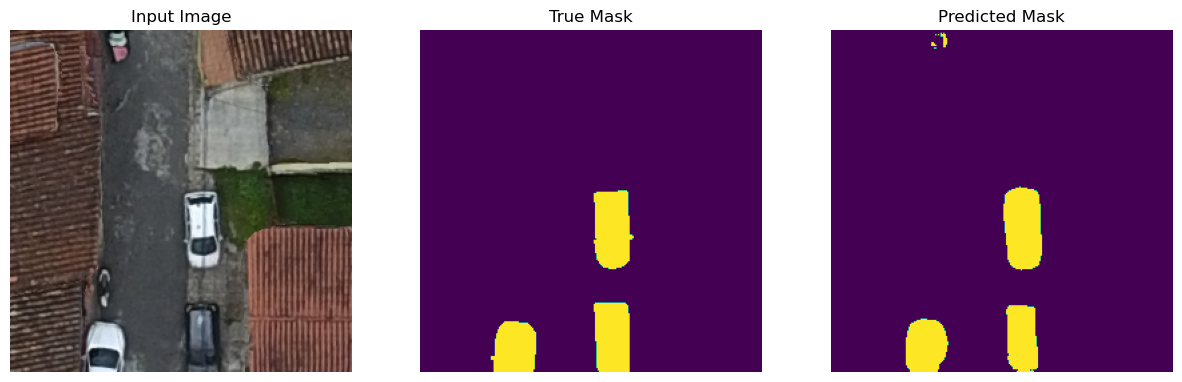

1/1 [==============================] - 0s 43ms/step


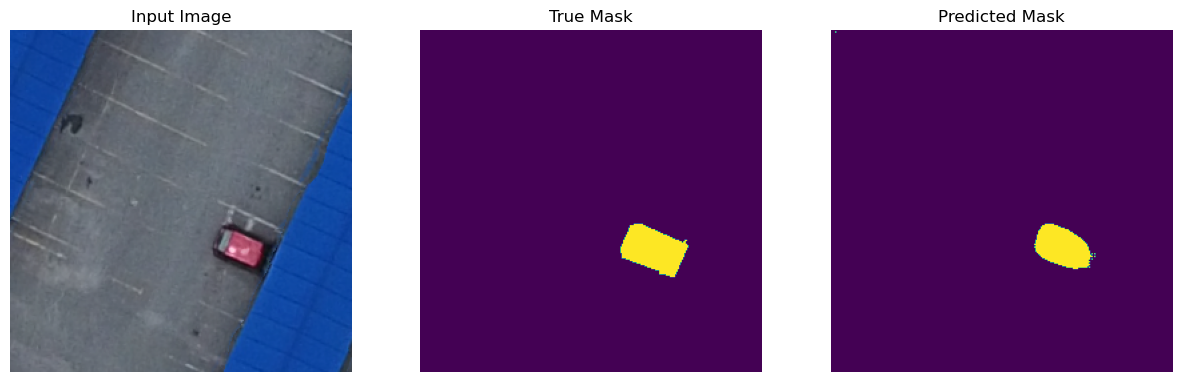

1/1 [==============================] - 0s 58ms/step


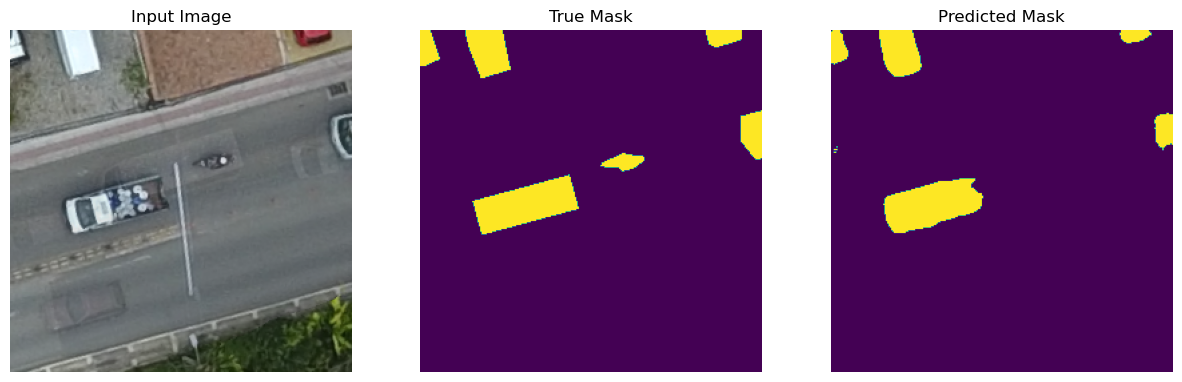

1/1 [==============================] - 0s 145ms/step


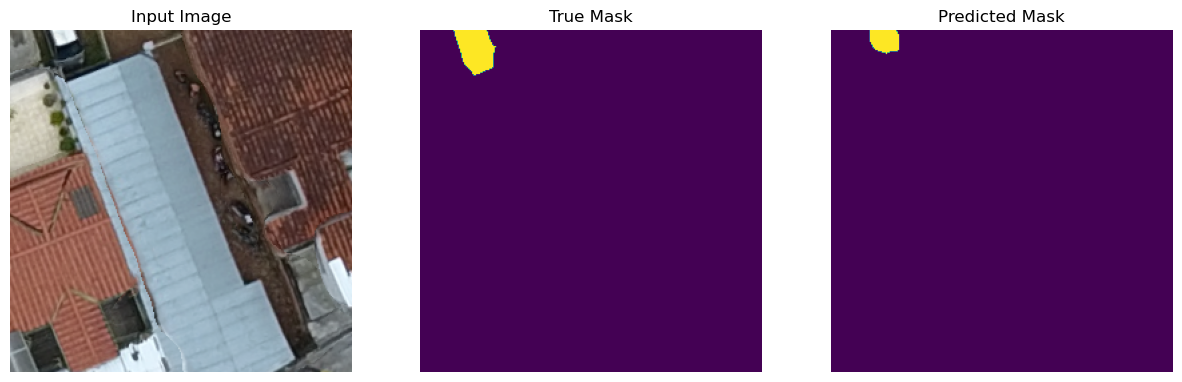

1/1 [==============================] - 0s 46ms/step


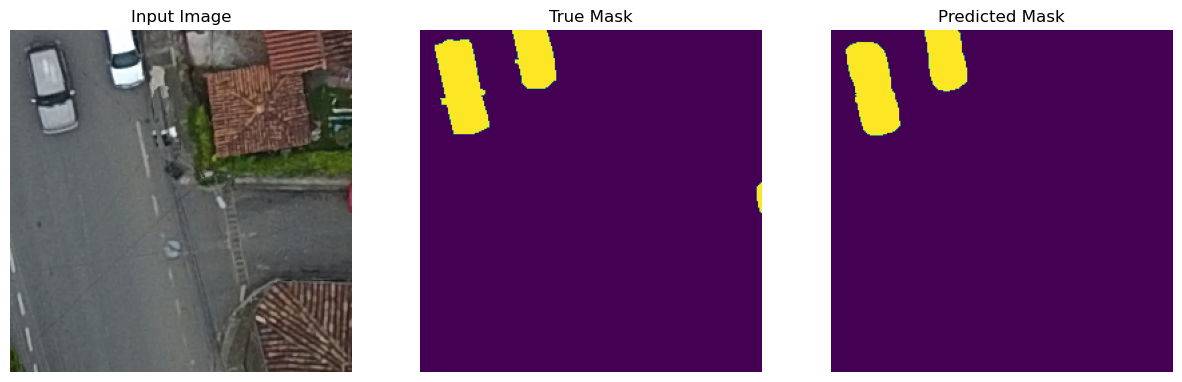

1/1 [==============================] - 0s 57ms/step


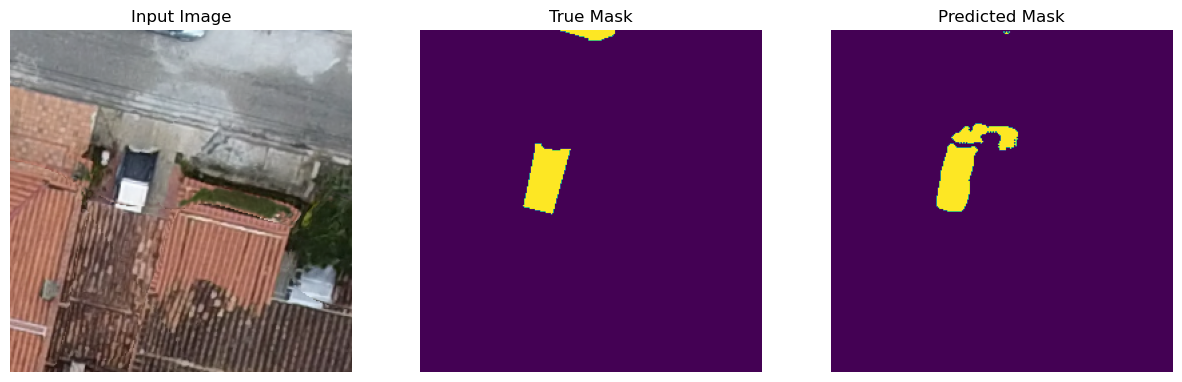

1/1 [==============================] - 0s 42ms/step


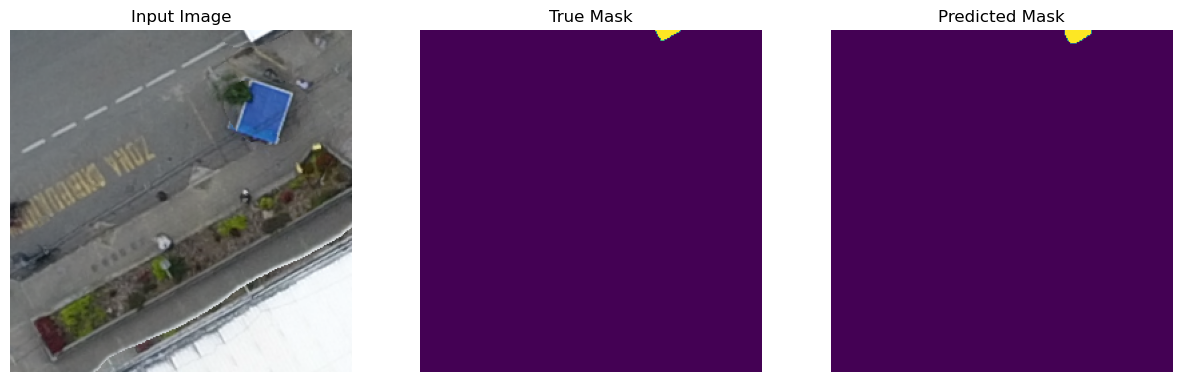

1/1 [==============================] - 0s 59ms/step


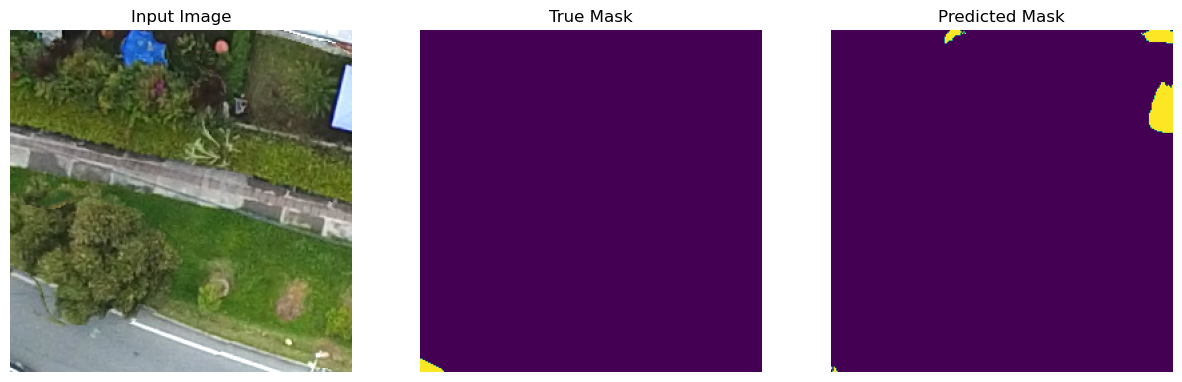

1/1 [==============================] - 0s 71ms/step


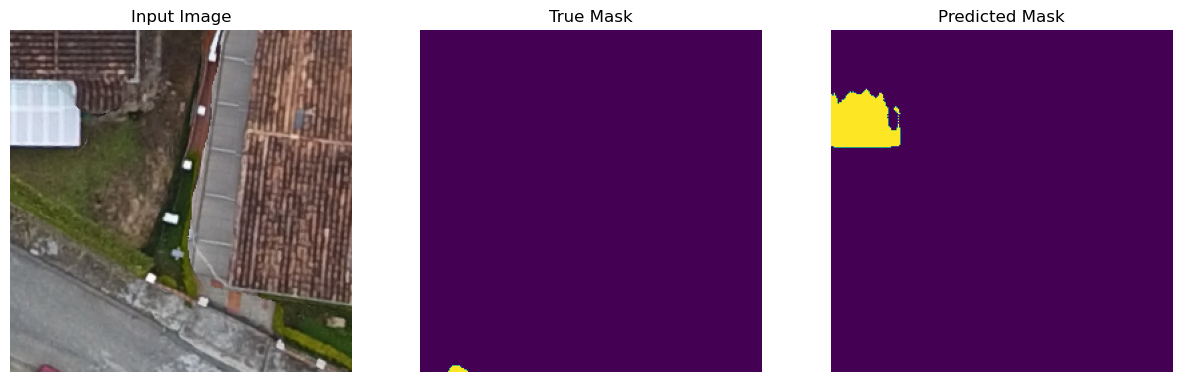

1/1 [==============================] - 0s 72ms/step


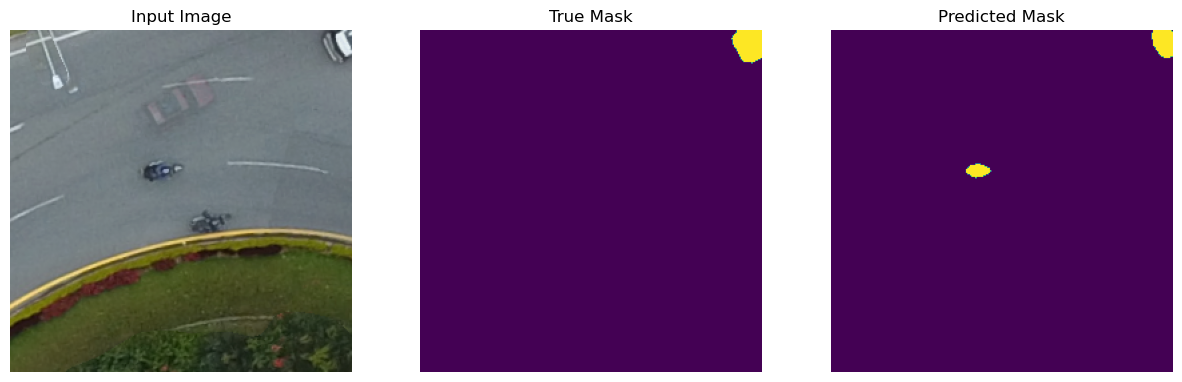

1/1 [==============================] - 0s 78ms/step


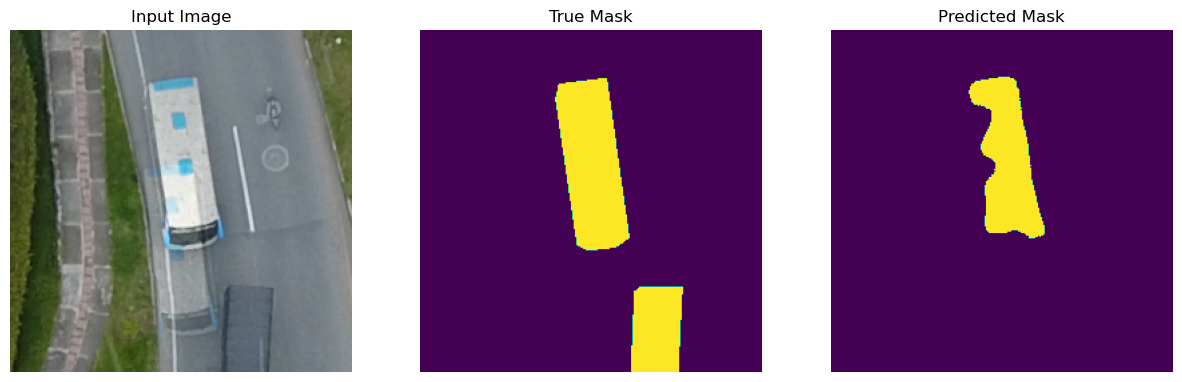

1/1 [==============================] - 0s 58ms/step


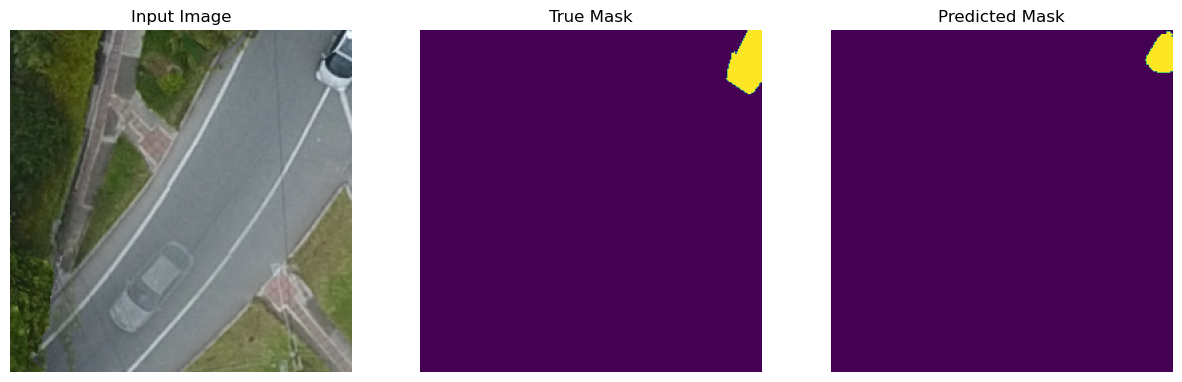

1/1 [==============================] - 0s 55ms/step


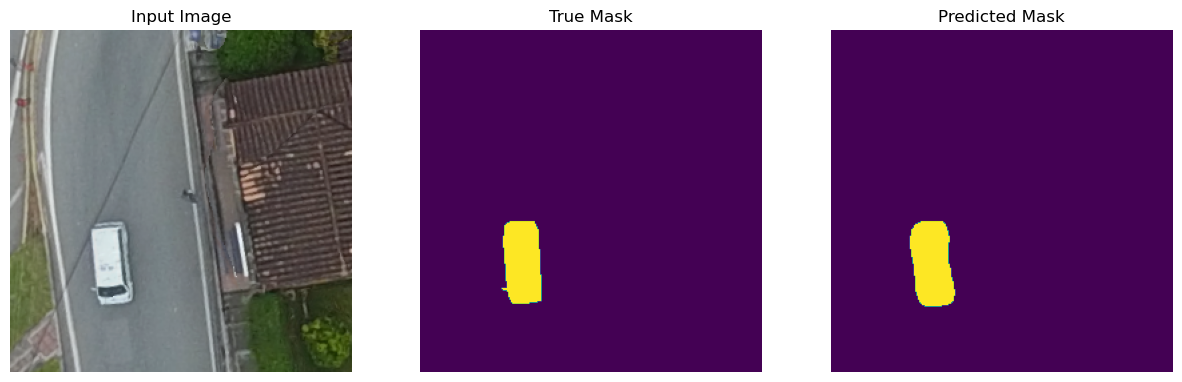

1/1 [==============================] - 0s 51ms/step


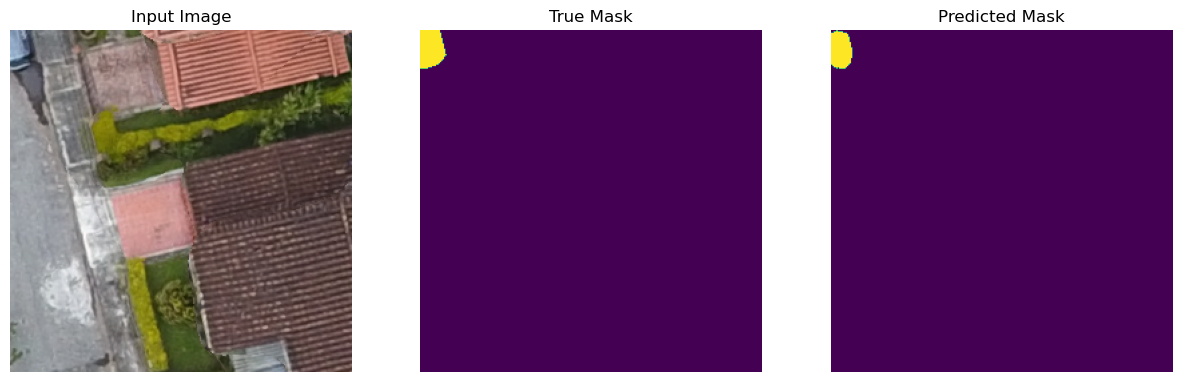

1/1 [==============================] - 0s 61ms/step


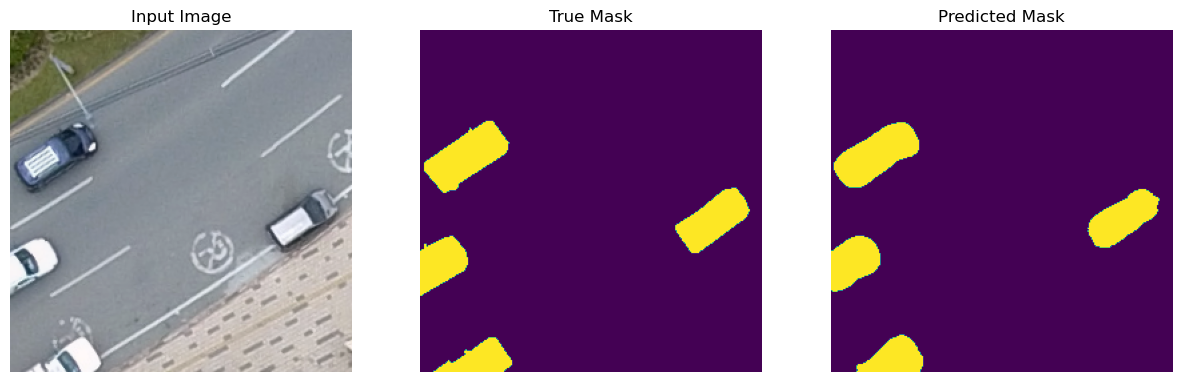

1/1 [==============================] - 0s 35ms/step


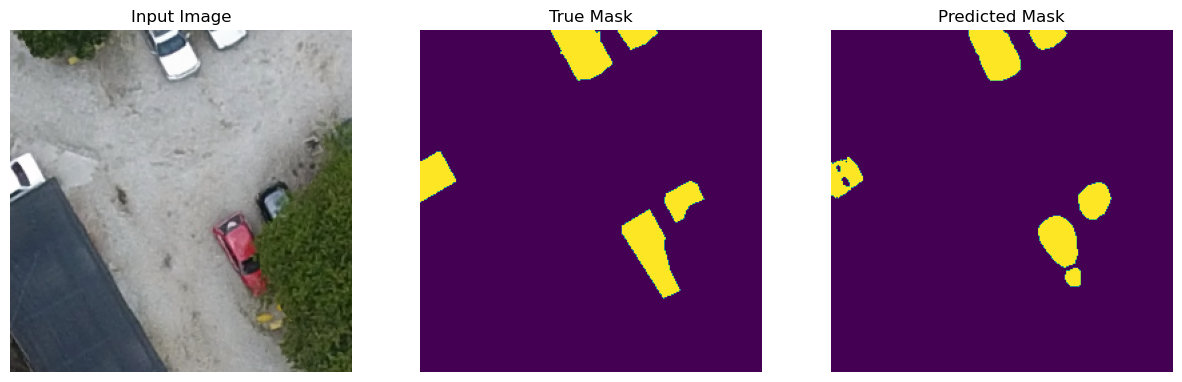

In [18]:
show_predictions(test_batches, unet_model, 20)

In [19]:
test_loss,test_acc =unet_model.evaluate(test_batches, verbose='False')
print("Test loss:", test_loss)
print("Test acc:", test_acc)

Test loss: 0.05284338817000389
Test acc: 0.9811475276947021
